# Preparing Data

In [2]:
import numpy as np
import scanpy as sc

adata = sc.read_h5ad("/home/jhaberbe/Projects/Personal/using_parameters_instead/data/16APR2025.h5ad")
folder_to_group_mapping = adata.obs[["folder", "group"]].drop_duplicates().set_index("folder")["group"].to_dict()

adata.obs["log_lipid_droplet_area"] = np.log1p(adata.obs["lipid_droplet_area"])
adata.obs["log_plin2_area"] = np.log1p(adata.obs["plin2_area"])
adata.obs["log_oil_red_o_area"] = np.log1p(adata.obs["oil_red_o_area"])
adata.obs["lipid_droplet"] = adata.obs["log_lipid_droplet_area"].gt(0).astype(int)
adata.obs["near_amyloid"] = adata.obs["distance_to_nearest_amyloid"].lt(60).astype(int)

/home/jhaberbe/Projects/Personal/using_parameters_instead/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
adata.obs.query("cell_type == 'Microglia-PVM'").groupby(["near_amyloid"])["lipid_droplet"].value_counts().unstack()

lipid_droplet,0,1
near_amyloid,,
0,31879,8446
1,1390,682


# Loading Modules

In [4]:
import sys
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("..")
from src.using_parameters_instead import formula, model, summary, statistics, plotting

importlib.reload(formula)
importlib.reload(model)
importlib.reload(summary)
importlib.reload(statistics)
importlib.reload(plotting)

<module 'src.using_parameters_instead.plotting' from '/home/jhaberbe/Projects/Personal/using_parameters_instead/scratch/../src/using_parameters_instead/plotting.py'>

# Primary Training Routing

In [5]:
import os
import pickle

output_folder = "/home/jhaberbe/Projects/Personal/using_parameters_instead/output/test"
try:
    os.mkdir(output_folder)
except:
    print("already exists")

already exists


In [7]:
for cell_type in adata.obs["cell_type"].unique():
    pass
    # We subset by cell type, and return grey vs white matter. 
subset = adata[adata.obs["cell_type"].eq(cell_type) & adata.obs["spatial_groups_2960"].eq("Grey")]

subset.obs["transcript_counts_red"] = np.log(subset.layers["transcript"].sum(axis=1) / subset.layers["transcript"].sum(axis=1).mean())

design_matrix_factory = formula.DesignMatrixFactory(
    "folder", 
    ["lipid_droplet", "near_amyloid"],
    intercept = False
)

differential_expression_testing = model.DifferentialExpressionTesting(
    model.NegativeBinomialModelFitter(),
    design_matrix_factory
)

results = differential_expression_testing.fit_model_over_features(
    adata=subset, 
    layer="transcript",
    min_expression=0.05,
    reset=False,
    offset=subset.obs["transcript_counts_red"]
)

pickle.dump(results, open(f"{output_folder}/{cell_type.replace('/', '-')}.pickle", "wb"))


100%|██████████| 366/366 [02:42<00:00,  2.25it/s]


In [31]:
cell_type = "Sst"
results = pickle.load(open("/home/jhaberbe/Projects/Personal/using_parameters_instead/output/test/Sst.pickle", "rb"))
results

{'ABCC9': <statsmodels.discrete.discrete_model.NegativeBinomialResultsWrapper at 0x7cc1e4de6f90>,
 'ABCG4': <statsmodels.discrete.discrete_model.NegativeBinomialResultsWrapper at 0x7cc1ec4d54f0>,
 'ACAT1': <statsmodels.discrete.discrete_model.NegativeBinomialResultsWrapper at 0x7cc1ec4d5d90>,
 'ACAT2': <statsmodels.discrete.discrete_model.NegativeBinomialResultsWrapper at 0x7cc1ec4d6630>,
 'ACSL1': <statsmodels.discrete.discrete_model.NegativeBinomialResultsWrapper at 0x7cc1ec4d6ed0>,
 'ACSL3': <statsmodels.discrete.discrete_model.NegativeBinomialResultsWrapper at 0x7cc1ec4d7770>,
 'ACSL4': <statsmodels.discrete.discrete_model.NegativeBinomialResultsWrapper at 0x7cc1ec4d7fb0>,
 'ADRA1A': <statsmodels.discrete.discrete_model.NegativeBinomialResultsWrapper at 0x7cc1ec2c0890>,
 'ADRA1B': <statsmodels.discrete.discrete_model.NegativeBinomialResultsWrapper at 0x7cc1ec2c1130>,
 'AIF1': <statsmodels.discrete.discrete_model.NegativeBinomialResultsWrapper at 0x7cc1ec2c19d0>,
 'ALK': <statsmodel

# Statistical Testing

Statistical tests here are performed using a t-test on the parameter estimates that we derive from the model between biological replicates.

# Common methods for testing by covariate and group.

In [ ]:
summarizer = summary.ModelResultSummarizer(design_matrix_factory)
summarizer.summary_dataframe(results, covariate="lipid_droplet")

<unknown>:1: SyntaxWarning: invalid escape sequence '\['


,ABCC9,ABCG4,ACAT1,ACAT2,ACSL1,ACSL3,ACSL4,ADRA1A,ADRA1B,AIF1,...,TRPC6,TSHZ2,TTYH1,UGT8,VCAN,VWC2L,WIF1,ZBBX,ZDHHC23,specimen
index,,,,,,,,,,,,,,,,,,,,,
folder[04-06],-2.515381,-1.946426,-0.429363,-0.994206,-2.318571,0.662701,-0.366849,-1.254494,-2.851238,-2.262822,...,-0.799841,-2.617326,-1.070740,-2.009142,-2.382629,-3.106262,-1.035344,-2.491478,-3.297464,04-06
folder[14-20],-2.678464,-1.840675,-0.582145,-1.399422,-1.906726,0.317788,-0.900760,-1.427463,-2.711091,-1.765502,...,-1.677969,-1.613948,-0.842788,-2.277752,-2.538841,-2.514491,-1.162276,-1.782138,-2.949471,14-20
folder[13-54],-2.358975,-2.082830,-0.994007,-1.557096,-2.125959,-0.131123,-1.861058,-1.448530,-2.347968,-1.642362,...,-3.422942,-1.015449,-0.612390,-1.910459,-2.488915,-2.281906,-2.334469,-1.298665,-2.419397,13-54
folder[05-27],-2.623840,-1.812676,-1.019534,-1.700844,-2.234527,0.003393,-1.677582,-1.101385,-2.425016,-2.522274,...,-3.399175,-0.842260,-0.163828,-2.458569,-2.183084,-2.434082,-1.100799,-1.830142,-2.848532,05-27
folder[15-27],-2.485297,-2.127820,-0.901271,-1.662304,-2.459096,-0.094136,-1.733003,-0.546282,-2.447187,-2.668685,...,-2.184650,-1.660532,-0.522234,-1.995764,-2.053931,-2.794556,-1.270993,-1.869632,-2.943111,15-27
folder[99-15],-2.589818,-2.209531,-1.031965,-1.888967,-2.245281,0.310280,-1.194149,-1.477075,-2.523888,-2.732050,...,-1.492556,-1.845531,-1.428257,-1.996441,-1.977470,-2.615091,-1.255669,-2.705667,-2.763327,99-15
folder[18-20],-2.657253,-2.144958,-0.485288,-1.033225,-1.925632,0.559428,-0.504423,-1.612894,-2.733297,-2.089379,...,-1.067340,-1.397197,-0.925030,-2.270511,-2.466630,-2.228263,-0.712414,-2.181906,-2.829345,18-20
folder[18-75],-2.959838,-1.613274,-0.280489,-1.257432,-1.902775,0.542132,-0.397039,-1.703472,-2.881933,-1.934444,...,-0.545243,-1.571413,-0.724287,-2.604384,-2.336387,-2.746597,-0.845358,-1.962698,-3.703487,18-75
folder[10-46],-2.383183,-1.982656,-1.168874,-2.092137,-2.199638,-0.194168,-2.091197,-1.352803,-1.943409,-3.120982,...,-3.141165,-0.872496,-0.117624,-1.877504,-2.208354,-2.848033,-1.635899,-1.697541,-3.130753,10-46


#### Global Effect
What is the effect on all cells for lipid droplet accumulation, irrespective of cognitive diagnosis. (One way t-test vs mean of 0)

/home/jhaberbe/Projects/Personal/using_parameters_instead/scratch/../src/using_parameters_instead/summary.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["interaction_term"] = df["index"] \


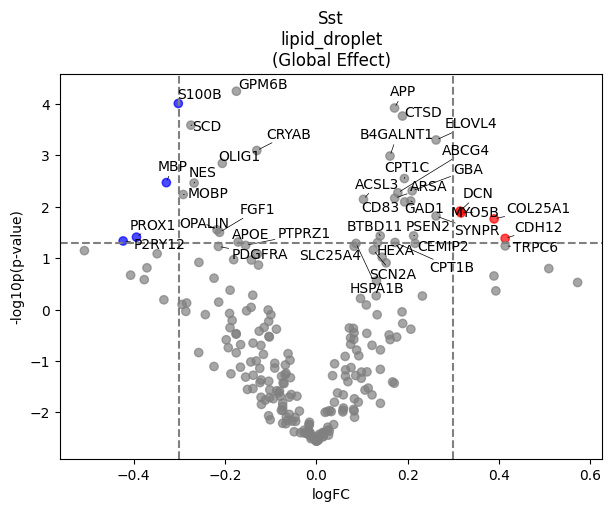

In [37]:
import scipy.stats

def global_effect_plot(results, output_location, design_matrix_factory=design_matrix_factory, covariate = "lipid_droplet"):
    summarizer = summary.ModelResultSummarizer(design_matrix_factory)
    df = summarizer.summary_dataframe(results, covariate=covariate)
    df = df.drop(["specimen", "interaction_term"], axis=1)

    table = pd.DataFrame({
        feature: {
            "statistic": test_result.statistic,
            "pvalue": test_result.pvalue * 366,
            "logFC": df[feature].mean(),
            "std": df[feature].std(),
        }
        for feature, test_result in {feature: scipy.stats.ttest_1samp(df[feature], 0) for feature in df.columns}.items()
    }).T.eval("log10p = -log10(pvalue)").rename(columns=dict(log10p = "-log10p"))

    plotting.volcano_plot(table, .3, top_n_genes=40)

    plt.title(f"{cell_type}\n{covariate}\n(Global Effect)")
    plt.savefig(output_location)

# for cell_type in adata.obs["cell_type"].unique():
results = pickle.load(open(f"/home/jhaberbe/Projects/Personal/using_parameters_instead/output/test/{cell_type.replace('/', '-')}.pickle", "rb"))
global_effect_plot(results, output_location=f"/home/jhaberbe/Projects/Personal/using_parameters_instead/output/test/{cell_type}.svg")

#### Group Level Differences
Differences between each group, 

/home/jhaberbe/Projects/Personal/using_parameters_instead/scratch/../src/using_parameters_instead/summary.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["interaction_term"] = df["index"] \
/home/jhaberbe/Projects/Personal/using_parameters_instead/scratch/../src/using_parameters_instead/summary.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["interaction_term"] = df["index"] \
/home/jhaberbe/Projects/Personal/using_parameters_instead/scratch/../src/using_parameters_instead/summary.py:45: Set

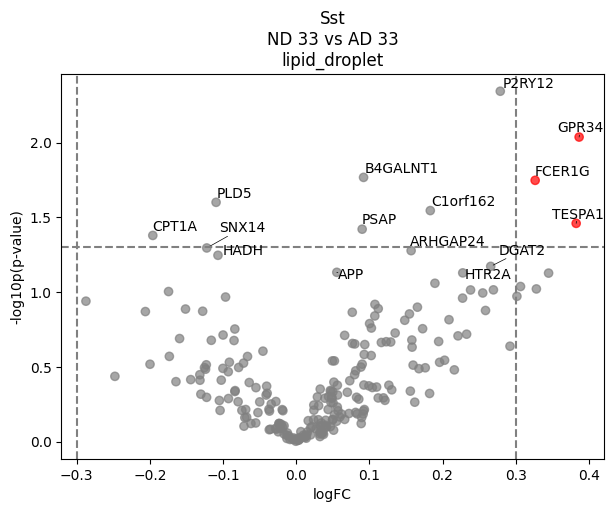

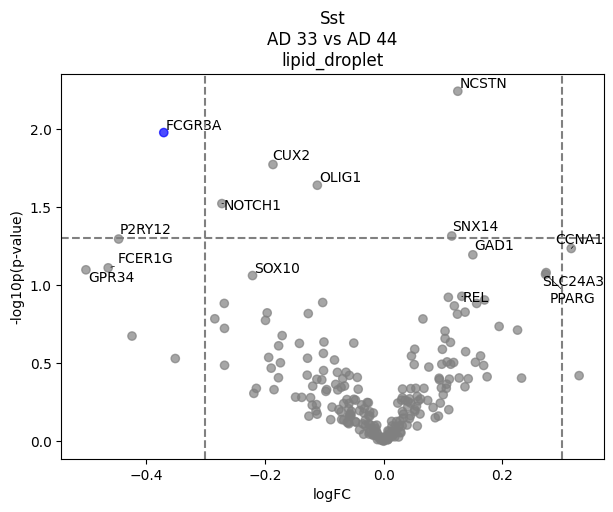

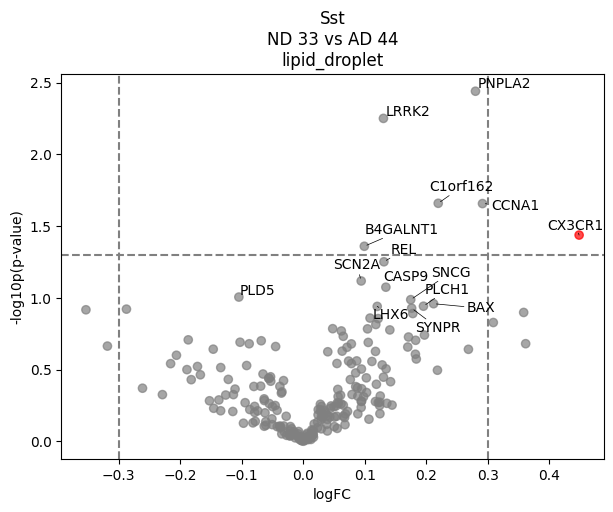

In [ ]:
def group_level_differences(results, output_location, covariate="lipid_droplet", design_matrix_factory=design_matrix_factory, g1="ND 33", g2="AD 33"):
    summarizer = summary.ModelResultSummarizer(design_matrix_factory)
    df = summarizer.summary_dataframe(results, covariate=covariate)
    df["group"] = df["specimen"].replace(folder_to_group_mapping)
    table = pd.DataFrame({
        feature: statistics.CoefficientStatistics(df).generate_stats_entry_dict(g1, g2, feature, equal_var=False)
        for feature in adata.var_names.intersection(df.columns)
    }).T
    ad_33 = table["logFC"]
    plotting.volcano_plot(table.query("abs(logFC) < 2"), .3)
    plt.title(f"{cell_type}\n{g1} vs {g2}\n{covariate}")
    plt.savefig(f"{output_location}/{cell_type.replace('/', '-')}_{g1}_{g2}.svg")

for cell_type in adata.obs["cell_type"].unique():
    results = pickle.load(open(f"/home/jhaberbe/Projects/Personal/using_parameters_instead/output/test/{cell_type.replace('/', '-')}.pickle", "rb"))
    group_level_differences(results, output_location=f"/home/jhaberbe/Projects/Personal/using_parameters_instead/output/test")
    group_level_differences(results, output_location=f"/home/jhaberbe/Projects/Personal/using_parameters_instead/output/test", g1="AD 33", g2="AD 44")
    group_level_differences(results, output_location=f"/home/jhaberbe/Projects/Personal/using_parameters_instead/output/test", g1="ND 33", g2="AD 44")

#### Group level differences

/home/jhaberbe/Projects/Personal/using_parameters_instead/scratch/../src/using_parameters_instead/summary.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["interaction_term"] = df["index"] \


<Axes: xlabel='group', ylabel='GPNMB'>

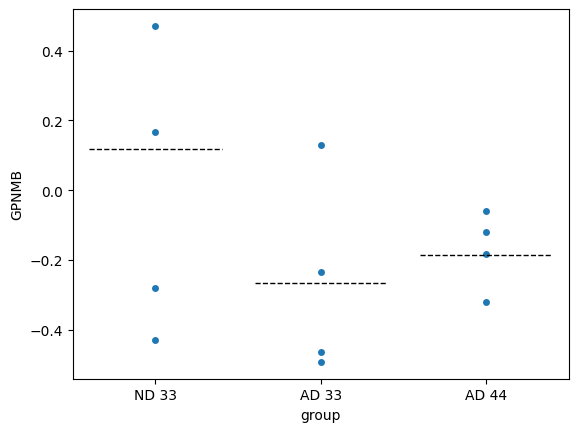

In [65]:
import seaborn as sns

gene = "GPNMB"

summarizer = summary.ModelResultSummarizer(design_matrix_factory)
df = summarizer.summary_dataframe(results, covariate="lipid_droplet")
df["group"] = df["specimen"].replace(folder_to_group_mapping)

sns.swarmplot(df, x="group", y=gene, order=["ND 33", "AD 33", "AD 44"])
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': 'dashed', 'lw': 1},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="group",
            y=gene,
            data=df.iloc[:-2],
            showfliers=False,
            showbox=False,
            showcaps=False)

#### One way t-test

<Axes: ylabel='GPNMB'>

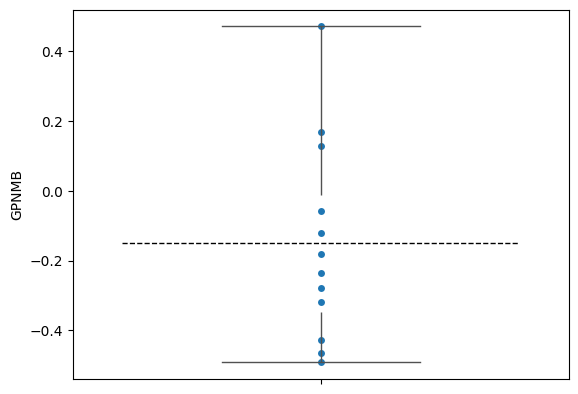

In [66]:
import seaborn as sns
gene = "GPNMB"

sns.swarmplot(df, y=gene)
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': 'dashed', 'lw': 1},
            medianprops={'visible': False},
            whiskerprops={'visible': True},
            zorder=10,
            y=gene,
            data=df,
            showfliers=False,
            showbox=False,
            showcaps=True)